#  Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan

- Geography: MENA + AP countries (MENAAP).
- Timeline: 2019-01-01 to 2024-12-31.
- Source: ACLED conflict events; population overlays from WorldPop 2020 UN-adjusted.

## Event inclusion criteria
- Fatality threshold: only events with fatalities > 0 are included in event and fatality counts.
- Protests:
  - Excluded: sub_event_type = "Peaceful protest".
  - Included when fatality threshold is met: "Protest with intervention" and "Excessive force against protesters".
- Other ACLED event types retained (subject to the fatality filter), such as: Battles; Explosions/Remote violence; Violence against civilians; Riots; Strategic developments.
- Duplicates in API pulls are dropped before analysis.

## Spatial aggregation and grid size
- Gridding scheme: Bing quadkey tiles clipped to country boundaries.
  - Level 12 (QK12) tiles for national/regional aggregations.
  - Level 13 (QK13) tiles to reflect smaller footprints in “people around events”.
- Approximate tile areas in the MENA/AP region (varies by latitude):
  - QK12: ~60–80 km²
  - QK13: ~20–30 km²
- Aggregation frequency: annual (calendar year). We sum Number of Events and Number of Fatalities over each grid and then to country/regional levels.

## Countries included
Afghanistan, Pakistan, Algeria, Morocco, Libya, Yemen, Iran, Iraq, Syria, Egypt, Lebanon, Djibouti, United Arab Emirates, Jordan, Palestine, Oman, Qatar, Saudi Arabia, Kuwait, Tunisia, Bahrain.

Note: The total number of conflict events (after applying the filters above) is computed dynamically in the next cell for transparency and reproducibility.

## Population overlays and denominators
- Population data: WorldPop 2020 UN-adjusted population raster.
- Denominators: national totals are obtained by summing WorldPop 2020 per-tile populations (not official census totals), so country totals may differ from statistical agency figures.
- For exposure/impact: we overlay conflict tiles and population tiles at the same quadkey level (QK12 or QK13 as configured).

## Impacted population definition ("people around conflict events")
- A tile is considered impacted if any conflict event in that tile had at least one fatality during the study period.
- Impacted population per country is the sum of population in all impacted tiles within that country (upper-bound interpretation; we do not apportion within-tile distances).
- Percent impacted = 100 × (impacted population) / (total population from WorldPop 2020) computed per country.


## Notes and caveats
- Grid area varies with latitude; figures are approximate.
- Excluding "Peaceful protest" and zero-fatality events reduces counts relative to broader unrest measures.
- ACLED event geocoding precision varies; results should be interpreted with this uncertainty in mind.


1. definitions, categories of violence
2. atleast one death in the event
3. year between which we do
4. number of conflicts total
5. when were these episodes by year 
6. per country episodes
7. people affected
8. % of people 


In [2]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
from bokeh.io import output_file

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel, HoverTool

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *

In [3]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
START_DATE1 = "2019-01-01"
END_DATE1 = "2020-12-31"

START_DATE2 = "2021-01-01"
END_DATE2 = "2022-12-31"

START_DATE3 = "2023-01-01"
END_DATE3 = "2024-12-31"

In [4]:
wb_region = 'MENAAP'

In [5]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [6]:
data1 = extraction.acled_api(
    # email_address=os.environ.get("ACLED_EMAIL"),
    # access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE1,
    end_date=END_DATE1
)

data2 = extraction.acled_api(
    countries=countries_of_interest,
    start_date=START_DATE2,
    end_date=END_DATE2
)

data3 = extraction.acled_api(
    countries=countries_of_interest,
    start_date=START_DATE3,
    end_date=END_DATE3
)

data = pd.concat([data1, data2, data3], ignore_index=True)

🔄 Using cached OAuth token


/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/MENA-FCV-economic-monitor/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Successfully retrieved 145470 records
🔄 Using cached OAuth token


/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/MENA-FCV-economic-monitor/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Successfully retrieved 123799 records
🔄 Using cached OAuth token


/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/MENA-FCV-economic-monitor/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Successfully retrieved 157463 records


In [7]:
data.drop_duplicates(inplace=True)
data.shape

(426634, 19)

In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.sort_values(by='timestamp', inplace=True, ascending=False)

In [9]:
processing.data_type_conversion(data)

In [10]:
data = data[data['sub_event_type']!='Peaceful protest']
data = data[data['fatalities']>0]
data['wb_region'] = wb_region

In [11]:
extracted_date = datetime.today().strftime('%Y%m%d')

last_date = data['event_date'].max()
last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [12]:
data.to_csv(f'../../data/conflict/acled_mena_raw_no_peaceful_protest_one_fatality{extracted_date}.csv')

## Conflict Events and Fatalities

In [13]:
start = data['event_date'].min().year
end = data['event_date'].max().year

In [14]:
# Report total number of conflict events after filters (no peaceful protests, fatalities > 0)
total_events = int(data.shape[0])
print(f"Total conflict events in the region from {start} to {end}: {total_events:,}")

Total conflict events in the region from 2019 to 2024: 74,943


In [15]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_national.to_csv(f'../../data/conflict/acled_national_annual_one_fatality_no_peaceful_protest_{extracted_date}')

In [16]:

conflict_national.loc[conflict_national['country']=='Palestine', 'country'] = 'West Bank and Gaza'
#regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

conflict_regional_yearly = processing.get_acled_by_group(data, ['wb_region'],freq='YS')
conflict_regional_yearly.to_csv(f'../../data/acled_one_fatality_no_peaceful_protest_{wb_region}_{extracted_date}')

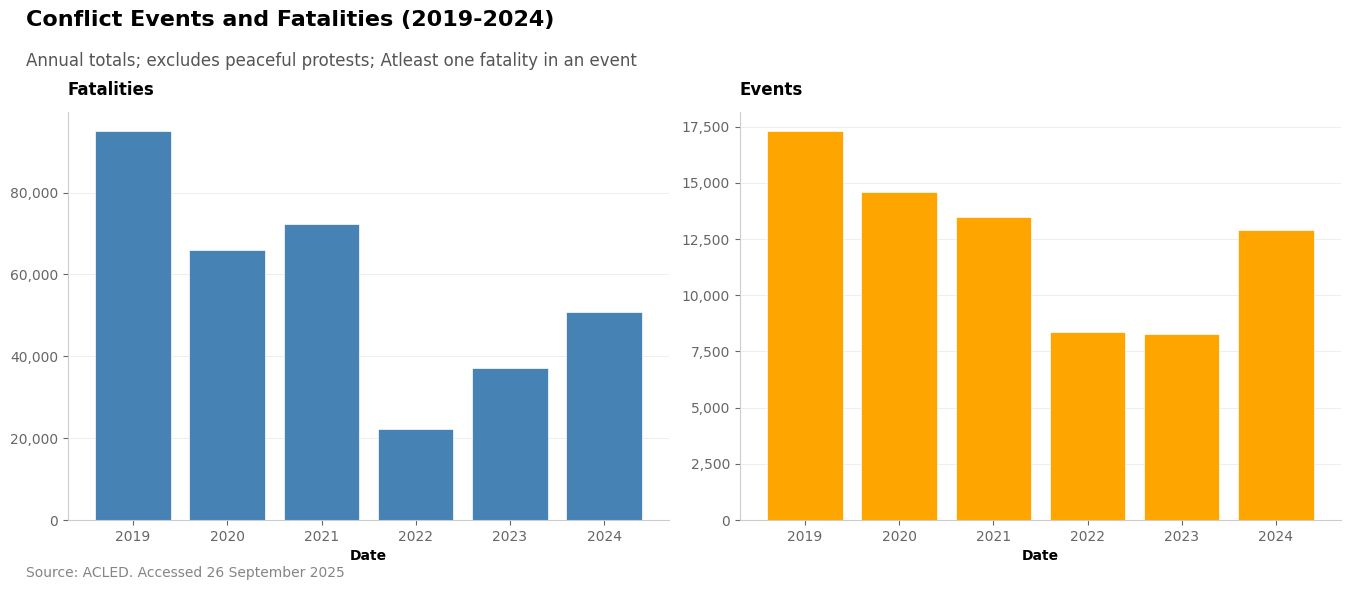

In [17]:
from conflict_visuals import plot_dual_bars_by_date

plot_dual_bars_by_date( data=conflict_regional_yearly, 
                       date_col='event_date', 
                       metrics_to_plot=['nrFatalities', 'nrEvents'], 
                       overall_title=f'Conflict Events and Fatalities ({start}-{end})', 
                       chart_subtitle='Annual totals; excludes peaceful protests; Atleast one fatality in an event', 
                       source_text=f'Source: ACLED. Accessed {extracted_date_formatted}');

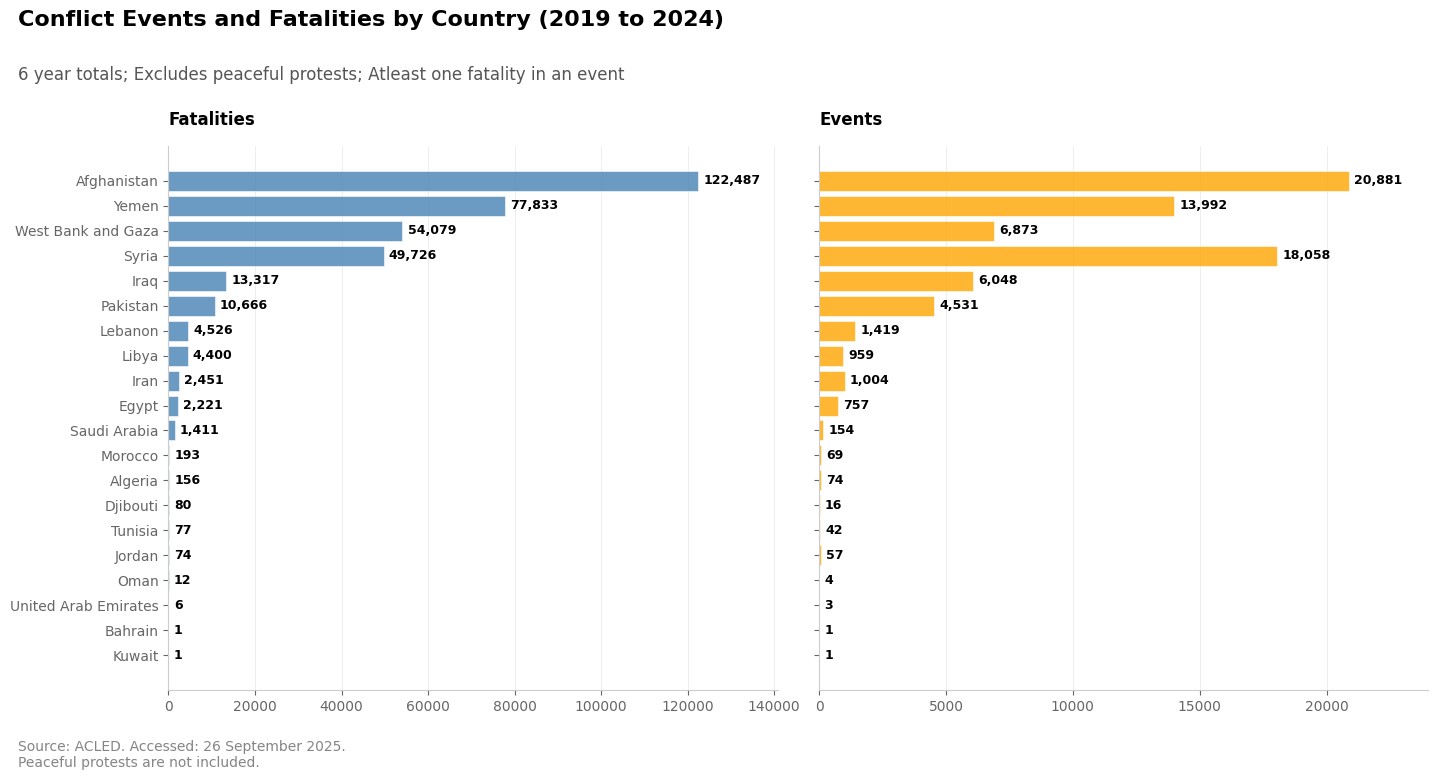

In [18]:
plot_dual_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = f'Conflict Events and Fatalities by Country ({start} to {end})',
    chart_subtitle='6 year totals; Excludes peaceful protests; Atleast one fatality in an event',
    source_text = f"""Source: ACLED. Accessed: {extracted_date_formatted}.\nPeaceful protests are not included."""
);

In [19]:
from boundaries_utils import *
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))

regional_boundary_quadkey13 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey13.gpkg')
regional_boundary_quadkey13['country'] = regional_boundary_quadkey13['country'].apply(lambda x: get_country_name_from_iso_code(x))

In [20]:
def get_national_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country'], freq='YS')
    df = df.groupby([index_column, 'country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

def get_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column], freq='YS')
    df = df.groupby([index_column])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

In [21]:
conflict_national_q12 = get_national_conflict_at_aggregation(regional_boundary_quadkey12, 'index', data)
conflict_national_q13 = get_national_conflict_at_aggregation(regional_boundary_quadkey13, 'index', data)


In [22]:
#boundaries_quad12.reset_index().to_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')

In [23]:
event_dict = {datetime(2023,10,8):'Start of the Gaza War'}

## People living in the same grid tile location as a conflict event with a fatality

In [44]:
pop = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad12.gpkg')
pop_quad13 = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad13.gpkg')
pop.rename(columns={'country':'country_code'}, inplace=True)

In [45]:
from boundaries_utils import get_country_name_from_iso_code

iso_codes = pop['country_code'].unique()
country_to_iso = {get_country_name_from_iso_code(iso): iso for iso in iso_codes}
iso_to_country = {iso: get_country_name_from_iso_code(iso) for iso in iso_codes}


#iso_to_country = {iso: ('Syria' if name == 'Syrian Arab Republic' else name) for iso, name in iso_to_country.items()}
country_to_iso = {('Syrian Arab Republic' if name == 'Syria' else
                   'Iran' if name == 'Iran, Islamic Republic of' else
                   'Palestine' if name == 'Palestine, State of' else
                   name): iso for name, iso in country_to_iso.items()}

iso_to_country = {iso: ('Syria' if name == 'Syrian Arab Republic' else
                        'Iran' if name == 'Iran, Islamic Republic of' else
                        'West Bank and Gaza' if name == 'Palestine, State of' else
                        name) for iso, name in iso_to_country.items()}


In [46]:
pop_total = pd.read_csv('../../data/population/regional_total_population_2020_worldpop.csv')
pop_total.drop(columns=['Unnamed: 0'], inplace=True)
pop_total.rename(columns={'iso3': 'country_code'}, inplace=True)

In [47]:
from boundaries_utils import * 

def get_impacted_population(conflict, population_path, pop_total):

    pop = gpd.read_file(population_path)

    pop.rename(columns={'country': 'country_code'}, inplace=True)
    pop['country'] = pop['country_code'].map(iso_to_country)


    conflict.loc[conflict['country']=='Syria', 'country'] = 'Syrian Arab Republic'

    conflict['country_code'] = conflict['country'].map(country_to_iso)

    merged = conflict.merge(pop[['index', 'population', 'country_code']],on=['index', 'country_code'], how='left')
    merged = merged[merged['nrFatalities']>0]
    merged = merged.groupby(['country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
    merged = merged.merge(pop_total, on=['country_code'])

    merged['pc_population'] = 100*merged['population']/merged['totalPopulation']

    merged['country'] = merged['country_code'].map(iso_to_country)
    merged.loc[merged['country']=='Palestine', 'country'] = 'West Bank and Gaza'

    return merged

In [49]:
impacted_quad12 = get_impacted_population(conflict_national_q12, 
                                          '../../data/population/polygons/MENAAP_pop_quad12.gpkg',
                                          pop_total)
impacted_quad12.to_csv(f'../../data/conflict/population_by_conflict_quad12_one_fatality_{extracted_date}.csv')


impacted_quad13 = get_impacted_population(conflict_national_q13,
                                           '../../data/population/polygons/MENAAP_pop_quad13.gpkg',
                                           pop_total)

impacted_quad13.to_csv(f'../../data/conflict/population_by_conflict_quad13_one_fatality_{extracted_date}.csv')

In [ ]:
conflict_national_q12.to_file(f'../../data/conflict/conflict_quad12_national_one_fatality_{extracted_date}.gpkg')

### People living in the same 60-80 sqkm grid tile (medium sized city) as a conflict with atleast one fatality

In [50]:
pc_total_pop = np.round(100*impacted_quad12['population'].sum()/pop_total['totalPopulation'].sum(),2)
print(f'{np.round(impacted_quad12['population'].sum()/1000000,2)} million people lived in the same area (60-80sqkm) as a conflict event in the last 6 years in MENAAP. \nThis is {pc_total_pop}% of the total population.')

244.83 million people lived in the same area (60-80sqkm) as a conflict event in the last 6 years in MENAAP. 
This is 34.27% of the total population.


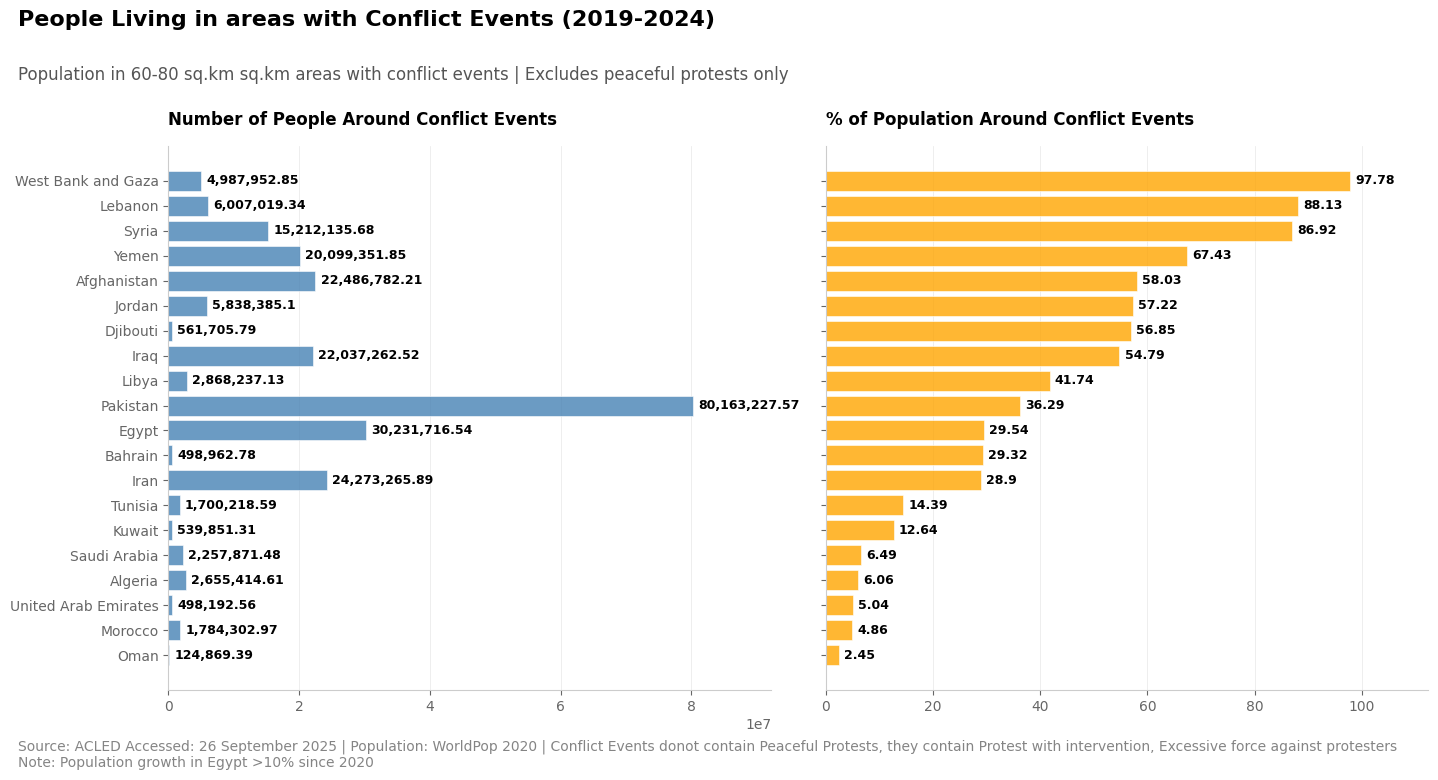

In [51]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =impacted_quad12,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = f'People Living in areas with Conflict Events ({start}-{end})',
    chart_subtitle='Population in 60-80 sq.km sq.km areas with conflict events | Excludes peaceful protests only',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 | Conflict Events donot contain Peaceful Protests, they contain Protest with intervention, Excessive force against protesters\nNote: Population growth in Egypt >10% since 2020'
);

### People living within ~20-30sqkm grid tile as a conflict with atleast one fatality

In [56]:
pc_total_pop = np.round(100*impacted_quad13['population'].sum()/pop_total['totalPopulation'].sum(),2)
print(f'{np.round(impacted_quad13['population'].sum()/1000000,2)} million people lived in the same area (20-30sqkm) as a conflict event in the last 6 years in MENAAP. \nThis is {pc_total_pop}% of the total population.')

137.98 million people lived in the same area (20-30sqkm) as a conflict event in the last 6 years in MENAAP. 
This is 19.31% of the total population.


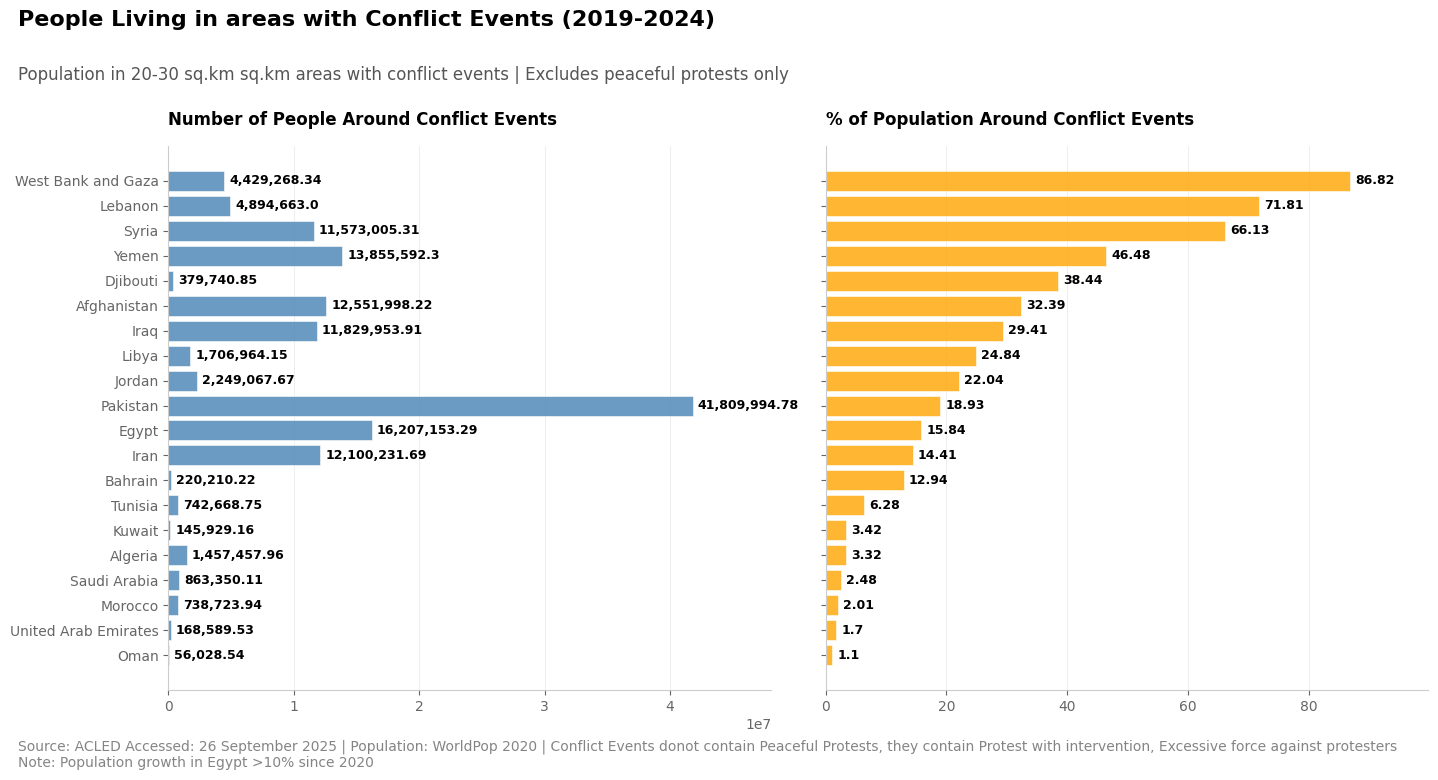

In [57]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =impacted_quad13,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = f'People Living in areas with Conflict Events ({start}-{end})',
    chart_subtitle='Population in 20-30 sq.km sq.km areas with conflict events | Excludes peaceful protests only',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 | Conflict Events donot contain Peaceful Protests, they contain Protest with intervention, Excessive force against protesters\nNote: Population growth in Egypt >10% since 2020'
);

In [59]:
# Bahrain is in UTM Zone 39N -> EPSG:32639 (units: meters). Compute area_km2 after reprojecting.
# Example: reproject Bahrain tiles from pop_quad13 and add area in km^2
bahrain = pop_quad13[pop_quad13['country'] == 'BHR'].copy()
if not bahrain.empty:
    bahrain_m = bahrain.to_crs(epsg=32639)
    bahrain_m['area_km2'] = bahrain_m.geometry.area / 1_000_000.0
    # Quick sanity: show a few rows
    bahrain_m[['index', 'country', 'population', 'area_km2']].head()
else:
    print("No Bahrain ('BHR') rows found in pop_quad13.")

bahrain_m

,index,country,population,geometry,area_km2
43810,1230230020023,BHR,NaN,"POLYGON ((471333.603 2906028.305, 471343.288 2...",19.142190
43811,1230221133132,BHR,405.945862,"POLYGON ((458057.816 2871104.685, 458071.829 2...",19.245297
43812,1230230020201,BHR,NaN,"POLYGON ((471323.928 2901663.489, 471333.603 2...",19.155052
43813,1230221133130,BHR,6597.649902,"POLYGON ((458071.829 2875479.7, 458085.857 287...",19.232500
43814,1230230020203,BHR,21337.615234,"POLYGON ((471314.263 2897297.216, 471323.928 2...",19.167906
...,...,...,...,...,...
43889,1230221131211,BHR,NaN,"POLYGON ((444988.381 2901748.612, 445006.942 2...",19.156150
43890,1230221131333,BHR,54549.773438,"POLYGON ((462507.639 2888582.659, 462520.236 2...",19.193878
43891,1230221133113,BHR,11514.117188,"POLYGON ((462482.486 2879839.897, 462495.056 2...",19.219519
43892,1230221133131,BHR,8703.980469,"POLYGON ((462469.93 2875466.343, 462482.486 28...",19.232325


### Comparing Grid Tile 14 and Grid Tile 13

In [72]:
import seaborn as sns

comparison = impacted_quad13.merge(impacted_quad12, on='country_code')[['country_code','population_x', 'population_y']]
comparison = comparison.rename(columns={'population_x': 'population_quad13', 'population_y': 'population_quad12'})
comparison['difference'] = comparison['population_quad13'] - comparison['population_quad12']
comparison['percent_change'] = 100*comparison['difference']/comparison['population_quad12']

# Format for display: population and difference in millions, percent as %
comparison_display = comparison.copy()
comparison_display['country'] = comparison_display['country_code'].map(iso_to_country)
comparison_display['population_quad13'] = (comparison_display['population_quad13'] / 1e6).round(2)
comparison_display['population_quad12'] = (comparison_display['population_quad12'] / 1e6).round(2)
comparison_display['difference'] = (comparison_display['population_quad13'] - comparison_display['population_quad12']).round(2)
comparison_display['percent_change'] = (100 * comparison_display['difference'] / comparison_display['population_quad12']).round(2)
comparison_display['percent_change'] = comparison_display['percent_change'].astype(str) + '%'
comparison_display.sort_values(by='country', ascending=True, inplace=True)
comparison_display

,country_code,population_quad13,population_quad12,difference,percent_change,country
0,AFG,12.55,22.49,-9.94,-44.2%,Afghanistan
4,DZA,1.46,2.66,-1.20,-45.11%,Algeria
2,BHR,0.22,0.50,-0.28,-56.0%,Bahrain
3,DJI,0.38,0.56,-0.18,-32.14%,Djibouti
5,EGY,16.21,30.23,-14.02,-46.38%,Egypt
6,IRN,12.10,24.27,-12.17,-50.14%,Iran
7,IRQ,11.83,22.04,-10.21,-46.32%,Iraq
8,JOR,2.25,5.84,-3.59,-61.47%,Jordan
9,KWT,0.15,0.54,-0.39,-72.22%,Kuwait
10,LBN,4.89,6.01,-1.12,-18.64%,Lebanon


## Country level temporal trends of conflict

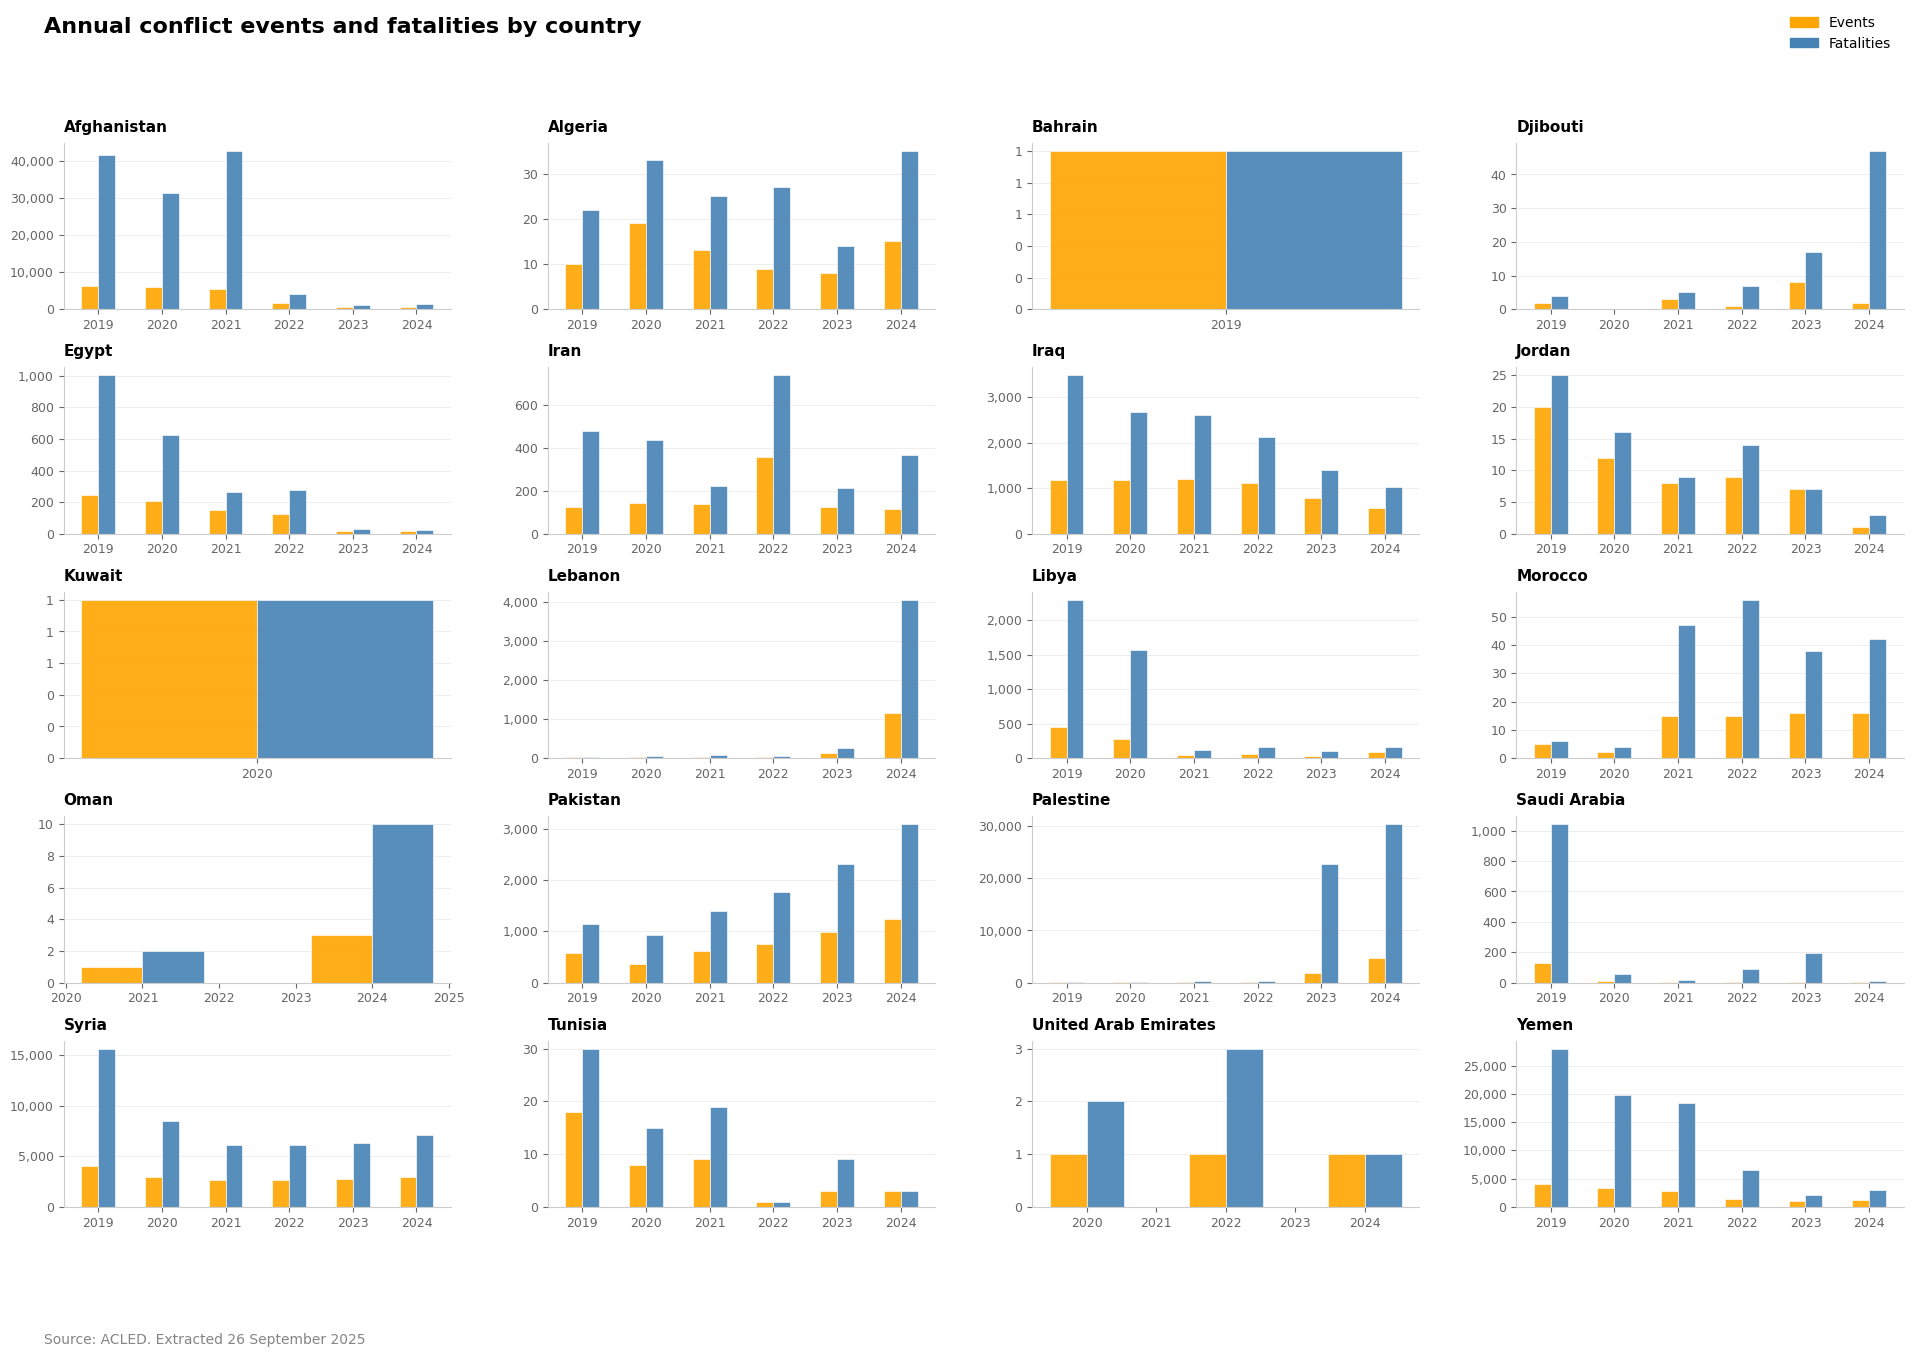

In [74]:
import pandas as pd

# If the module is in the same folder as this notebook (notebooks/conflict), this import will work:
from conflict_visuals import plot_annual_country_bars

conflict_national_yearly = processing.get_acled_by_group(data, columns=['country'], freq='YS')

# Start from your annual data if you already have it
df = conflict_national_yearly.copy()

# Ensure there is a proper datetime column named 'event_date'
if 'event_date' not in df.columns:
    if 'year' in df.columns:
        # When you have a 'year' column in int/str form
        df['event_date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')
    else:
        # Fallback: try to coerce any likely date column
        for cand in ['date', 'period', 'year_date']:
            if cand in df.columns:
                df['event_date'] = pd.to_datetime(df[cand], errors='coerce')
                break

# Make sure metric columns are numeric and NaN-safe
for col in ['nrEvents', 'nrFatalities']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Optional: subset to a list of countries if you’ve defined it
if 'countries_of_interest' in globals():
    df = df[df['country'].isin(countries_of_interest)]

metric_display = {
    'nrEvents': {'title': 'Events', 'color': 'orange'},
    'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
}

fig = plot_annual_country_bars(
    data=df,
    country_col='country',
    date_col='event_date',
    metrics=['nrEvents', 'nrFatalities'],
    metric_display_info=metric_display,
    # If your df is already annual (like conflict_national_yearly), pass None to skip re-aggregating
    freq=None,
    ncols=4,                    # tweak columns per row if you like
    figsize=(20, 14),           # adjust size for readability
    overall_title='Annual conflict events and fatalities by country',
    chart_subtitle=None,
    source_text=(
        f"Source: ACLED. Extracted {extracted_date_formatted}"
        if 'extracted_date_formatted' in globals() else "Source: ACLED"
    ),
    sharey=False                # set True if you want all subplots on same y-scale
)

fig;
